In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import MNIST
from tqdm import trange

from nedotorch import nn, optim

# Digit recognition

## Data preparation

Loading the MNIST dataset

In [2]:
mndata = MNIST("./data")
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

print("Train size:", len(train_images))
print("Test size:", len(test_images))

Train size: 60000
Test size: 10000


In [3]:
train_data = list(zip(train_images[:55000], train_labels[:55000]))
validation_data = list(zip(train_images[55000:], train_labels[55000:]))
test_data = list(zip(test_images, test_labels))

Let's look at samples

Image size: 784
Label: 5


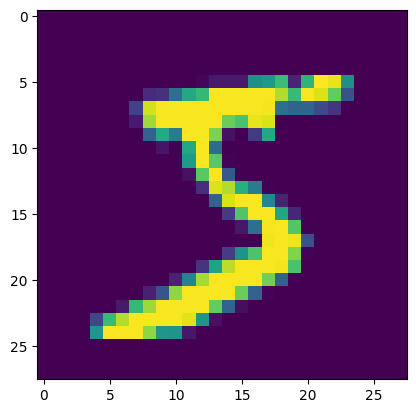

In [4]:
print("Image size:", len(train_images[0]))
print("Label:", train_labels[0])
plt.imshow(np.array(train_images[0]).reshape(28, 28));

For better stability of a model, we will normilize images (translate values to $[-1; 1]$).

Since there is a classification problem, it will be reasonable to use One-Hot encoding for labels.

In [5]:
def normilize(image):
    return (2 * (np.array(image) / 255 - 0.5)).reshape(-1, 1)

def onehot_encode(label):
    result = np.zeros(10)
    result[label] = 1.

    return result.reshape(-1, 1)

## Model

Neural network consists of 3 fully-connected layers with ReLU activation and softmax layer (included in CrossEntropyLoss) for probability distribution.

In [6]:
net = nn.Sequence(
    nn.Linear(784, 392),
    nn.ReLU(),
    nn.Linear(392, 10),
)

## Training

In [7]:
def train(model, criterion, optimizer, data):
    loss = 0
    accuracy = 0
    for sample in data:
        input = normilize(sample[0])
        label = onehot_encode(sample[1])

        optimizer.zero_grad()
        output = model(input) 
        loss += criterion(output, label)
        accuracy += np.argmax(output) == sample[1]
        criterion.backward()
        optimizer.step()
    
    return loss / len(train_images), accuracy / len(data)

In [8]:
def validate(model, criterion, data):
    loss = 0
    accuracy = 0
    for sample in data:
        input = normilize(sample[0])
        label = onehot_encode(sample[1])
        
        output = model(input) 
        loss += criterion(output, label)
        accuracy += np.argmax(output) == sample[1]
    
    return loss / len(data), accuracy / len(data)

Epoch 9: 100%|██████████| 10/10 [07:49<00:00, 46.98s/it, train_accuracy=0.889, train_loss=0.163, validation_accuracy=0.845, validation_loss=1.82]


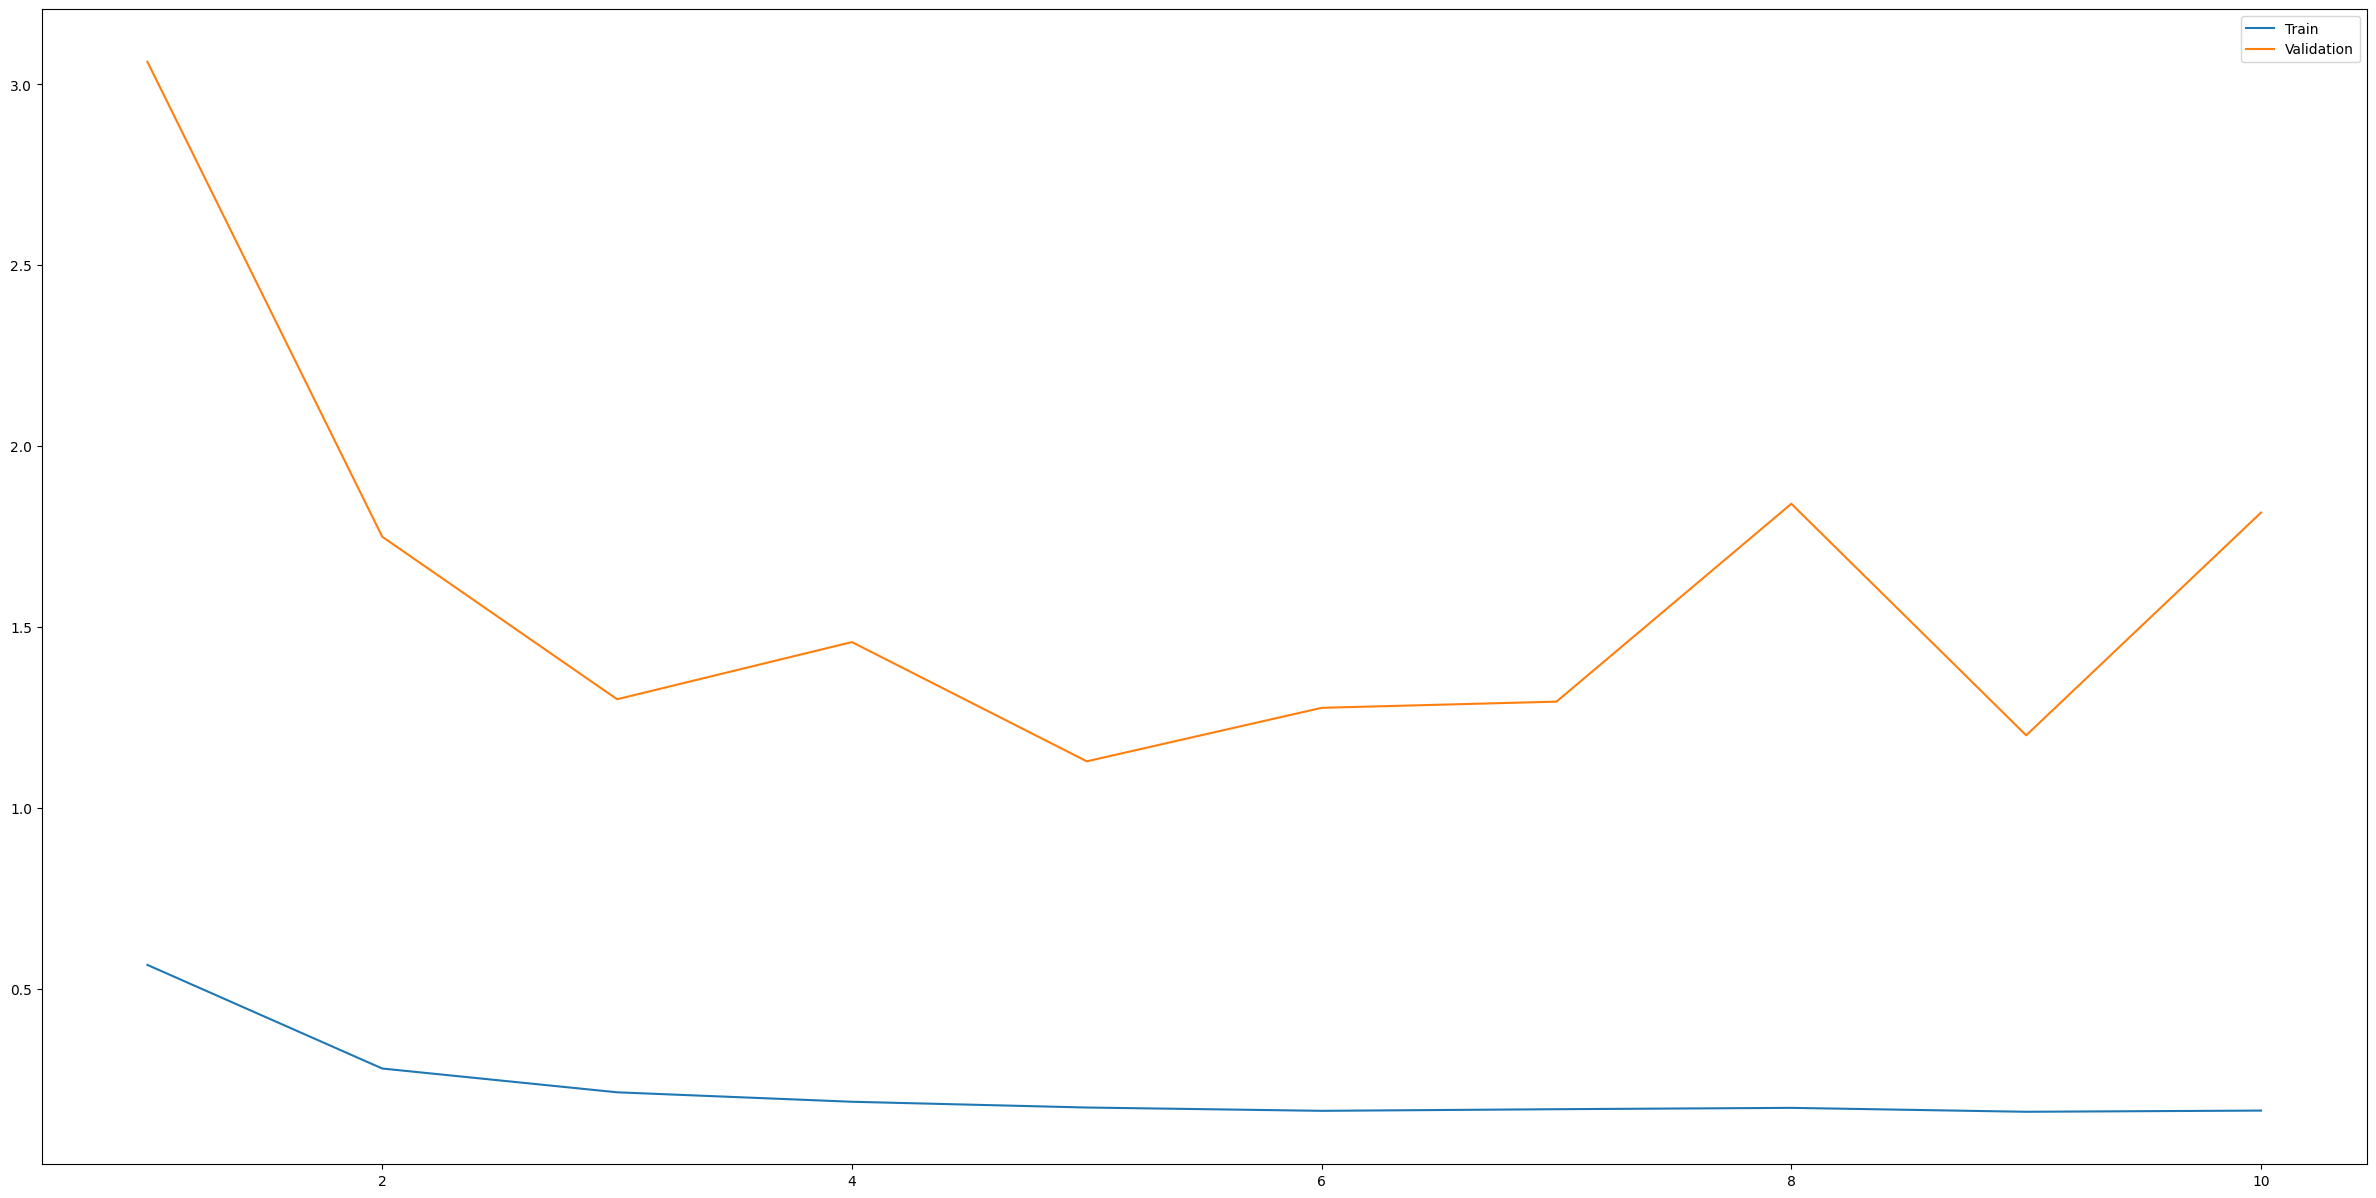

In [9]:
criterion = nn.CrossEntropyLoss(net)
optimizer = optim.SGD(net.parameters, 10e-4)

epochs = np.arange(1, 11)
train_losses = []
validation_losses = []

with trange(len(epochs)) as t:
    for epoch in t:
        t.set_description(f"Epoch {epoch}")
        train_loss, train_accuracy = train(net, criterion, optimizer, test_data)
        validation_loss, validation_accuracy = validate(net, criterion, validation_data)
        t.set_postfix(
            train_loss=train_loss,
            train_accuracy=train_accuracy,
            validation_loss=validation_loss,
            validation_accuracy=validation_accuracy,
        )
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)

plt.figure(figsize=(30, 15))
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, validation_losses, label="Validation")
plt.legend()
plt.show()

## Testing

In [10]:
accuracy = 0
for sample in test_data:
    input = normilize(sample[0])
    label = onehot_encode(sample[1])
    
    output = net(input) 
    accuracy += np.argmax(output) == sample[1]

accuracy /= len(test_data) / 100

print(f"Accuracy: {accuracy}%")

Accuracy: 85.57%
